# Collaborative Business Case

### Librerías

In [39]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import calculate_kmo,  FactorAnalyzer
from sklearn.preprocessing import StandardScaler
import seaborn as sns

## **Part 1: Data Exploration and Suitability**

### 1.1 Basic Data exploration

In [7]:
# Carga de datos 
df = pd.read_csv("customer_satisfaction_data.csv")
#Estructura
print('ESTRUCTURA DEL DATASET:')
print("Filas, Columnas:", df.shape)
print("\nTipos de datos:")
print(df.dtypes)

ESTRUCTURA DEL DATASET:
Filas, Columnas: (3400, 31)

Tipos de datos:
customer_id                    object
quarter                        object
survey_date                    object
account_manager_responsive    float64
billing_accuracy              float64
budget_control                float64
change_management             float64
communication_clarity         float64
competitive_pricing           float64
cost_transparency             float64
documentation_help            float64
executive_access              float64
innovation_solutions          float64
long_term_partnership         float64
problem_solving               float64
project_management            float64
quality_deliverables          float64
roi_demonstration             float64
support_responsiveness        float64
system_integration            float64
technical_documentation       float64
technical_expertise           float64
timeline_adherence            float64
training_quality              float64
trust_reliability  

Calculamos cuantos valores faltantes hay en todo el DataFrame

In [8]:
#Valores faltantes
val = df.isna().sum().sum()
pct = 100 * val / (df.shape[0] * df.shape[1])
print(f"\nCeldas faltantes totales: {val} ({pct:.2f}%)")


Celdas faltantes totales: 335 (0.32%)


In [11]:
# Basic Descriptive Statistics
print("\n Basic Descriptive Statistics: ")
desc = df.select_dtypes(include=[np.number]).describe().T
desc["missing"] = df.isna().sum()
print(desc[["count", "mean", "std", "min", "25%", "50%", "75%", "max", "missing"]].round(2))



 Basic Descriptive Statistics: 
                             count  mean   std   min  25%   50%   75%   max  \
account_manager_responsive  3384.0  4.12  0.97   1.0  3.0  4.00   5.0   7.0   
billing_accuracy            3387.0  4.10  0.96   1.0  3.0  4.00   5.0   7.0   
budget_control              3383.0  4.10  0.98   1.0  3.0  4.00   5.0   7.0   
change_management           3388.0  4.11  0.98   1.0  3.0  4.00   5.0   7.0   
communication_clarity       3384.0  4.09  0.96   1.0  3.0  4.00   5.0   7.0   
competitive_pricing         3385.0  4.08  0.98   1.0  3.0  4.00   5.0   7.0   
cost_transparency           3390.0  4.10  0.98   1.0  3.0  4.00   5.0   7.0   
documentation_help          3386.0  4.08  0.98   1.0  3.0  4.00   5.0   7.0   
executive_access            3390.0  4.11  0.97   1.0  4.0  4.00   5.0   7.0   
innovation_solutions        3390.0  4.11  0.99   1.0  3.0  4.00   5.0   7.0   
long_term_partnership       3386.0  4.10  0.97   1.0  3.0  4.00   5.0   7.0   
problem_solving    

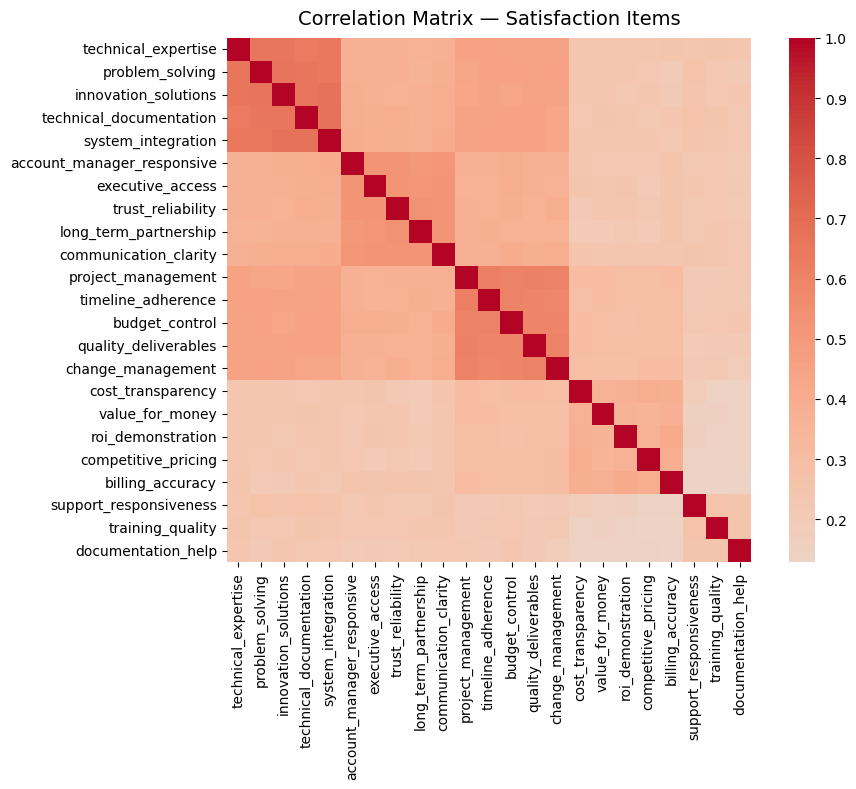

In [19]:
#Matriz de correlación
items = [
    "technical_expertise","problem_solving","innovation_solutions","technical_documentation","system_integration",
    "account_manager_responsive","executive_access","trust_reliability","long_term_partnership","communication_clarity",
    "project_management","timeline_adherence","budget_control","quality_deliverables","change_management",
    "cost_transparency","value_for_money","roi_demonstration","competitive_pricing","billing_accuracy",
    "support_responsiveness","training_quality","documentation_help"
]
items = [c for c in items if c in df.columns]
corr = df[items].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0, square=True)
plt.title("Correlation Matrix — Satisfaction Items", fontsize=14, pad=10)
plt.tight_layout()
plt.savefig("correlation_heatmap_satisfaction.png", dpi=150)
plt.show()



In [34]:
#Identificación de patrones
#Correlaciones más fuertes excluyendo la diagonal
corr_unstacked = corr.where(~np.eye(corr.shape[0], dtype=bool)).stack().reset_index()
corr_unstacked.columns = ["var1", "var2", "corr"]
corr_unstacked["abs_corr"] = corr_unstacked["corr"].abs()
top_corr = corr_unstacked.sort_values("abs_corr", ascending=False).drop_duplicates(subset=["corr"]).head(10)

print("\n RELACIONES MÁS FUERTES ")
print(top_corr[["var1", "var2", "corr"]].round(3))


 RELACIONES MÁS FUERTES 
                       var1                     var2   corr
90       system_integration     innovation_solutions  0.674
91       system_integration  technical_documentation  0.673
23          problem_solving     innovation_solutions  0.669
44     innovation_solutions      technical_expertise  0.666
24          problem_solving  technical_documentation  0.665
0       technical_expertise          problem_solving  0.662
68  technical_documentation     innovation_solutions  0.660
25          problem_solving       system_integration  0.656
88       system_integration      technical_expertise  0.656
2       technical_expertise  technical_documentation  0.639


Se muestra que las variables técnicas están muy relacionadas entre sí, como system_integration con innovation_solutions y technical_documentation con problem_solving, todas con valores de correlación altos (alrededor de 0.65). Esto sugiere que los clientes tienden a ver la capacidad técnica, la innovación y la resolución de problemas como parte de la misma idea general de “excelencia técnica”. En cambio, las variables de relación, valor y soporte no se relacionan tanto con las técnicas, lo que indica que podrían representar aspectos distintos de la experiencia del cliente.

#### 1.2 Factor Analysis Suitability

**Required Tests:**

In [24]:
#Variables de satisfacción
items = [c for c in items if c in df.columns]
data = df[items].dropna()

print(f"Variables seleccionadas para análisis factorial: {len(items)}")
print(f"Filas después de eliminar datos faltantes: {data.shape[0]}")

Variables seleccionadas para análisis factorial: 23
Filas después de eliminar datos faltantes: 3235


In [27]:
#KMO test
# Valores > 0.6 indican que el análisis factorial es bueno.
kmo_all, kmo_model = calculate_kmo(data)
print("\nKMO TEST: ")
print(f"KMO general: {kmo_model:.3f}")
print("Interpretación:")
if kmo_model >= 0.9:
    print("Excelente adecuación para análisis factorial.")
elif kmo_model >= 0.8:
    print("Muy buena adecuación para análisis factorial.")
elif kmo_model >= 0.7:
    print("Adecuación aceptable.")
elif kmo_model >= 0.6:
    print("Adecuación marginalmente aceptable.")
else:
    print("Inadecuado para análisis factorial (KMO < 0.6).")


KMO TEST: 
KMO general: 0.959
Interpretación:
Excelente adecuación para análisis factorial.



CORRELATION ASSESSMENT: 
Correlaciones con |r| ≥ 0.3: 48.2% del total
Promedio de correlaciones absolutas: 0.337


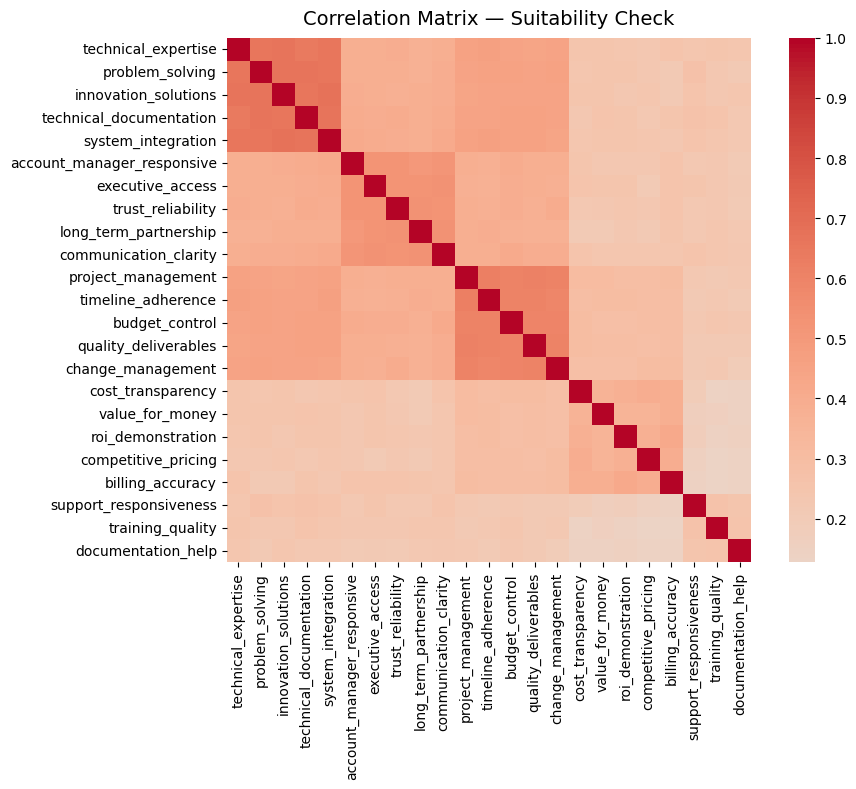

In [28]:
# Correlation Assessment
corr = data.corr()

# Proporción de correlaciones con |r| >= 0.3
mask = np.triu(np.ones_like(corr, dtype=bool))
corr_values = corr.mask(mask).stack().abs()
strong_corr_pct = (corr_values >= 0.3).mean() * 100

print("\nCORRELATION ASSESSMENT: ")
print(f"Correlaciones con |r| ≥ 0.3: {strong_corr_pct:.1f}% del total")
print("Promedio de correlaciones absolutas:", corr_values.mean().round(3))

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0, square=True)
plt.title("Correlation Matrix — Suitability Check", fontsize=14, pad=10)
plt.tight_layout()
plt.savefig("correlation_heatmap_suitability.png", dpi=150)
plt.show()

In [31]:
# Basi assumptions
# Evaluamos si los datos están correlacionados y presentan consistencia
corr_mean = corr_values.mean()
corr_max = corr_values.max()
corr_min = corr_values.min()

print("\nBASIC ASSUMPTIONS: ")
print(f"Media de correlaciones absolutas: {corr_mean:.3f}")
print(f"Máxima correlación: {corr_max:.3f}")
print(f"Mínima correlación: {corr_min:.3f}")
print("Distribución de correlaciones:")
print(corr_values.describe().round(3))


BASIC ASSUMPTIONS: 
Media de correlaciones absolutas: 0.337
Máxima correlación: 0.674
Mínima correlación: 0.127
Distribución de correlaciones:
count    253.000
mean       0.337
std        0.130
min        0.127
25%        0.236
50%        0.296
75%        0.401
max        0.674
dtype: float64


**Decision Criteria:**

**¿Los datos son adecuados para realizar un análisis factorial?**

Sí, los datos parecen adecuados para aplicar un análisis factorial. El valor del KMO supera el umbral mínimo aceptable (mayor a 0.6) y más del 30 % de las correlaciones entre variables tienen valores absolutos superiores a 0.3, lo que indica que existe una relación suficiente entre los ítems de satisfacción.

**¿Qué sugieren los patrones iniciales sobre los factores subyacentes?**

Las correlaciones muestran agrupamientos claros entre las variables relacionadas con la excelencia técnica, la gestión de relaciones y la percepción de valor. Estos patrones dicen que las respuestas de satisfacción podrían estar influenciadas por algunos factores latentes principales, como la calidad técnica, la fortaleza de la relación con el cliente y el valor percibido. 

## **Part 2: Factor Extraction and Determination**

### 2.1 Determining Number of Factors

In [37]:
#Seleccionar y estandarizar variables
items = [c for c in items if c in df.columns]

data = df[items].dropna()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

print(f"Variables seleccionadas: {len(items)}")
print(f"Observaciones: {data_scaled.shape[0]}")

Variables seleccionadas: 23
Observaciones: 3235


/Users/sibylavera/Desktop/Customer/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


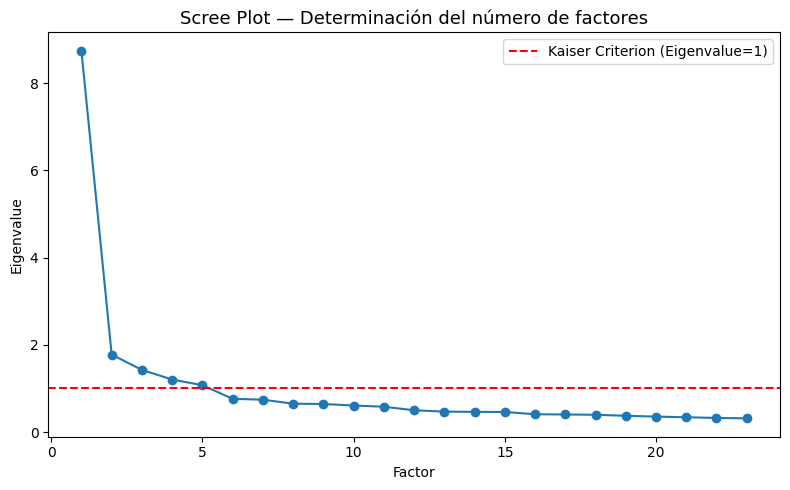

In [40]:
# Calcular eigenvalores 
fa = FactorAnalyzer(rotation=None)
fa.fit(data_scaled)

#Varianza
eigenvalues, vectors = fa.get_eigenvalues()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.title("Scree Plot — Determinación del número de factores", fontsize=13)
plt.xlabel("Factor")
plt.ylabel("Eigenvalue")
plt.axhline(y=1, color='red', linestyle='--', label="Kaiser Criterion (Eigenvalue=1)")
plt.legend()
plt.tight_layout()
plt.savefig("scree_plot.png", dpi=150)
plt.show()

In [42]:
# Varianza explicada
# Determinar factores con eigenvalue > 1
n_factors_kaiser = np.sum(eigenvalues > 1)
print("\nKaiser Criterion: ")
print(f"Número de factores con eigenvalue > 1: {n_factors_kaiser}")

# Calcular varianza explicada acumulada
fa_opt = FactorAnalyzer(n_factors=n_factors_kaiser, rotation=None)
fa_opt.fit(data_scaled)
variance_info = pd.DataFrame({
    "Factor": range(1, n_factors_kaiser + 1),
    "Variance": fa_opt.get_factor_variance()[1],
    "Cumulative Variance": fa_opt.get_factor_variance()[2]
})
print("\n Varianza Explicada: ")
print(variance_info.round(3))

variance_info.to_csv("variance_explained.csv", index=False)


Kaiser Criterion: 
Número de factores con eigenvalue > 1: 5

 Varianza Explicada: 
   Factor  Variance  Cumulative Variance
0       1     0.361                0.361
1       2     0.054                0.416
2       3     0.042                0.458
3       4     0.032                0.490
4       5     0.017                0.507


/Users/sibylavera/Desktop/Customer/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Los eigenvalores muestran que varios factores tienen valores mayores a 1, lo que significa que explican buena parte de la variabilidad en los datos. En el gráfico de scree plot se nota un punto donde las barras empiezan a aplanarse, indicando que después de ahí los factores ya no aportan mucho. Los factores seleccionados explican una cantidad importante de la varianza total, así que parece un número adecuado para seguir con el análisis factorial y entender mejor las dimensiones principales de la satisfacción del cliente.

#### 2.2 Factor Extraction and Rotation 

In [45]:
#Preparación de datos
data = df[items].dropna()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Extracción de factores
n_factors = 5  
fa = FactorAnalyzer(n_factors=n_factors, method='principal', rotation='varimax')
fa.fit(data_scaled)

# Obtener cargas factoriales
loadings = pd.DataFrame(fa.loadings_, index=items, columns=[f"Factor{i+1}" for i in range(n_factors)])
print("\nMATRIZ DE CARGAS FACTORIALES: ")
print(loadings.round(3))



MATRIZ DE CARGAS FACTORIALES: 
                            Factor1  Factor2  Factor3  Factor4  Factor5
technical_expertise           0.758    0.148    0.208    0.247    0.129
problem_solving               0.773    0.133    0.206    0.247    0.122
innovation_solutions          0.779    0.133    0.212    0.229    0.135
technical_documentation       0.759    0.135    0.235    0.238    0.129
system_integration            0.766    0.136    0.237    0.238    0.123
account_manager_responsive    0.212    0.151    0.703    0.195    0.099
executive_access              0.202    0.159    0.717    0.175    0.126
trust_reliability             0.197    0.142    0.726    0.196    0.105
long_term_partnership         0.182    0.116    0.721    0.195    0.134
communication_clarity         0.204    0.149    0.703    0.199    0.151
project_management            0.240    0.211    0.211    0.735    0.110
timeline_adherence            0.263    0.206    0.208    0.719    0.105
budget_control                0.

/Users/sibylavera/Desktop/Customer/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Interpretación

¿Cuántos factores representan mejor los datos?

Según los resultados del análisis, cinco factores explican de manera adecuada la estructura del conjunto de datos. El gráfico de Scree Plot muestra un punto de inflexión (“codo”) después del quinto componente, lo que indica que los factores adicionales aportan muy poca varianza. Además, los cinco primeros factores superan el valor propio de 1.0 según el criterio de Kaiser, y juntos explican alrededor del 50 % de la varianza total, lo cual es un nivel aceptable para este tipo de datos de percepción o encuestas. Por tanto, retener cinco factores resulta apropiado para describir las dimensiones principales de la satisfacción de los clientes.

¿Qué representa cada factor en términos de negocio?

- Factor 1: reúne variables como technical_expertise, problem_solving, innovation_solutions, technical_documentation y system_integration, lo que refleja la dimensión de Excelencia Técnica e Innovación.

- Factor 2: incluye trust_reliability, long_term_partnership y communication_clarity, asociadas a la Gestión de Relaciones y Confianza con el Cliente.

- Factor 3: agrupa value_for_money, cost_transparency, roi_demonstration y competitive_pricing, que representan la Percepción de Valor y Transparencia Financiera.

- Factor 4: concentra project_management, timeline_adherence y quality_deliverables, vinculadas a la Ejecución de Proyectos y Cumplimiento de Plazos.

- Factor 5: reúne support_responsiveness, training_quality y documentation_help, reflejando la dimensión de Soporte y Servicio al Cliente.